In [33]:
import pandas as pd
import numpy as np
from matplotlib import colors, cm, text, pyplot as plt
import matplotlib.patches as patches
from cmcrameri import cm
import math

In [34]:
import peakutils
import pickle

In [193]:
VISUALISATION_FILE = '/home/ubuntu/visualise-three-d-255.pkl'

In [194]:
with open(VISUALISATION_FILE, 'rb') as f:
    visualise_d = pickle.load(f)

In [195]:
anchor_point_s = visualise_d['anchor_point_s']
initial_candidate_region_df = visualise_d['initial_candidate_region_df']
peak_mz_lower = visualise_d['peak_mz_lower']
peak_mz_upper = visualise_d['peak_mz_upper']
scan_df = visualise_d['scan_df']
scan_valleys_df = visualise_d['scan_valleys_df']
scan_lower = visualise_d['scan_lower']
candidate_region_with_isotope_clusters_df = visualise_d['candidate_region_with_isotope_clusters_df']
candidate_region_with_isotope_series_clusters_df = visualise_d['candidate_region_with_isotope_series_clusters_df']
rt_df = visualise_d['rt_df']
rt_valleys_df = visualise_d['rt_valleys_df']
rt_lower = visualise_d['rt_lower']
rt_upper = visualise_d['rt_upper']

In [196]:
minimum_pixel_intensity = 50
maximum_pixel_intensity = 500

In [197]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=minimum_pixel_intensity, vmax=maximum_pixel_intensity, clip=True)

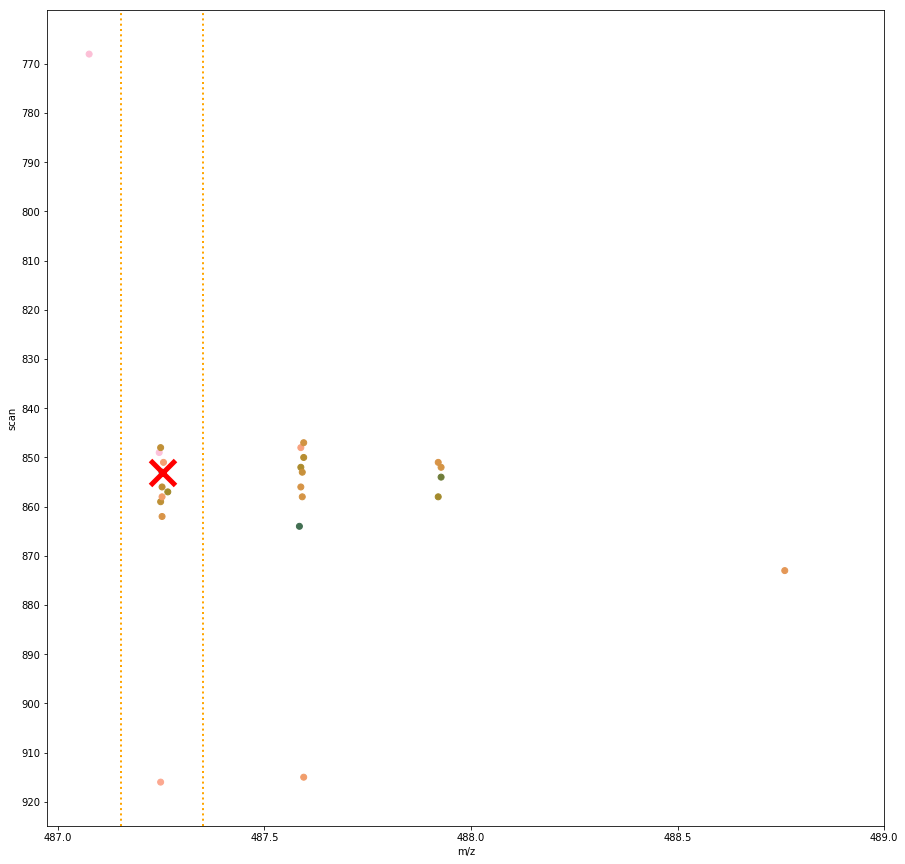

In [198]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(initial_candidate_region_df.mz, initial_candidate_region_df.scan, c=initial_candidate_region_df.intensity, cmap=colour_map, norm=norm)
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, label='anchor point')

plt.axvline(x=peak_mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=peak_mz_upper, linestyle=':', color='orange', linewidth=2)

nearest = 0.5
range_l = round(initial_candidate_region_df.mz.min() / nearest) * nearest
range_u = round(initial_candidate_region_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(initial_candidate_region_df.scan.min() / nearest) * nearest
range_u = round(initial_candidate_region_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [199]:
upper_x = scan_valleys_df[scan_valleys_df.scan > anchor_point_s.scan].scan.min()
if math.isnan(upper_x):
    upper_x = scan_df.scan.max()
lower_x = scan_valleys_df[scan_valleys_df.scan < anchor_point_s.scan].scan.max()
if math.isnan(lower_x):
    lower_x = scan_df.scan.min()

scan_lower = lower_x
scan_upper = upper_x

In [200]:
scan_extract_df = scan_df[(scan_df.scan >= scan_lower) & (scan_df.scan <= scan_upper)]

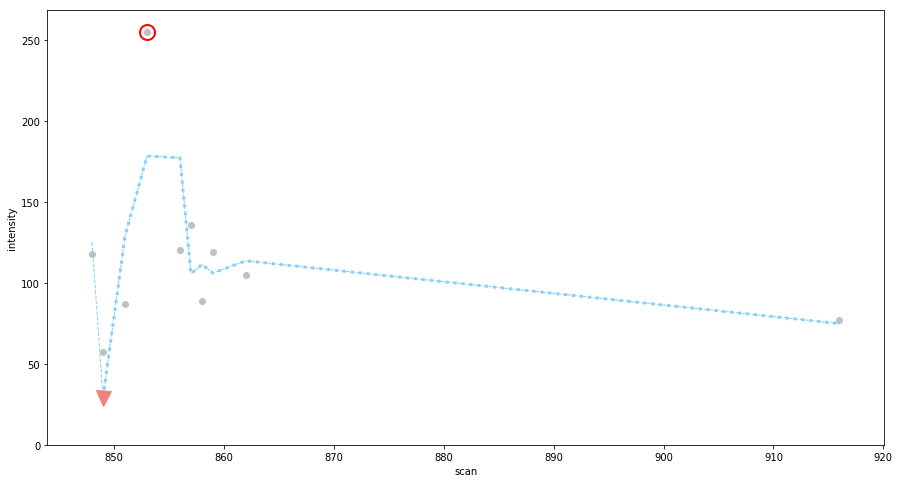

In [201]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_df.scan, scan_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(scan_extract_df.scan, scan_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(scan_valleys_df.scan, scan_valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.ylim(bottom=0)

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [202]:
colour_map = plt.get_cmap('gist_ncar')
norm = colors.Normalize(vmin=0, vmax=candidate_region_with_isotope_clusters_df.cluster.max(), clip=False)

In [203]:
# determine a colour for each cluster
cluster_colour_l = []
for group_name,group_df in candidate_region_with_isotope_clusters_df.groupby(['cluster'], as_index=False):
    c = colour_map(norm(group_name), bytes=False)[:3]
    cluster_colour_l.append((group_name, c))
cluster_colour_df = pd.DataFrame(cluster_colour_l, columns=['cluster','colour'])

In [204]:
# give each point a colour
candidate_region_df = pd.merge(candidate_region_with_isotope_clusters_df, cluster_colour_df, how='left', left_on=['cluster'], right_on=['cluster'])


In [205]:
candidate_region_df.sample(n=3)

,frame_id,mz,scan,intensity,retention_time_secs,point_id,cluster,colour
7,16387,487.255764,851,87,1838.341292,87036,0,"(0.0, 0.0, 0.502)"
5,16387,487.252302,858,89,1838.341292,86614,0,"(0.0, 0.0, 0.502)"
20,16387,488.759337,873,98,1838.341292,112335,-1,"(0.0, 0.0, 0.502)"


In [206]:
# calculate the cluster centroids
centroids_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    if group_name >= 0:
        mz_centroid = peakutils.centroid(group_df.mz, group_df.intensity)
        scan_centroid = peakutils.centroid(group_df.scan, group_df.intensity)
        centroids_l.append((group_name, mz_centroid, scan_centroid))
centroids_df = pd.DataFrame(centroids_l, columns=['cluster','mz','scan'])

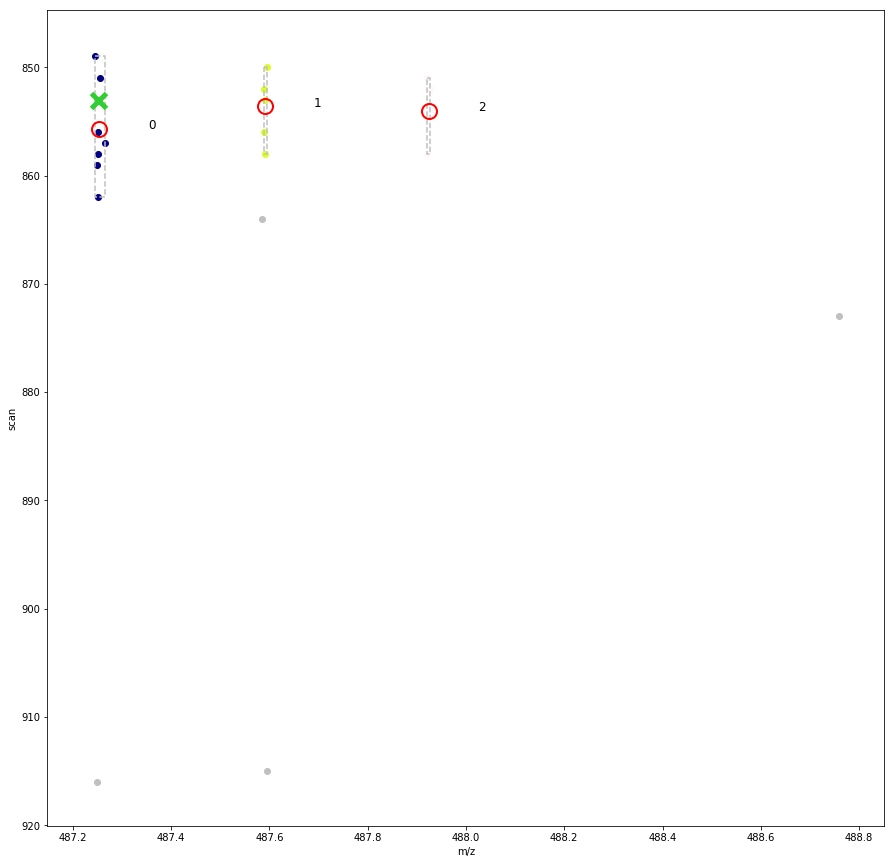

In [207]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [208]:
candidate_region_df = candidate_region_with_isotope_series_clusters_df
# give each point a colour
candidate_region_df = pd.merge(candidate_region_with_isotope_series_clusters_df, cluster_colour_df, how='left', left_on=['cluster'], right_on=['cluster'])


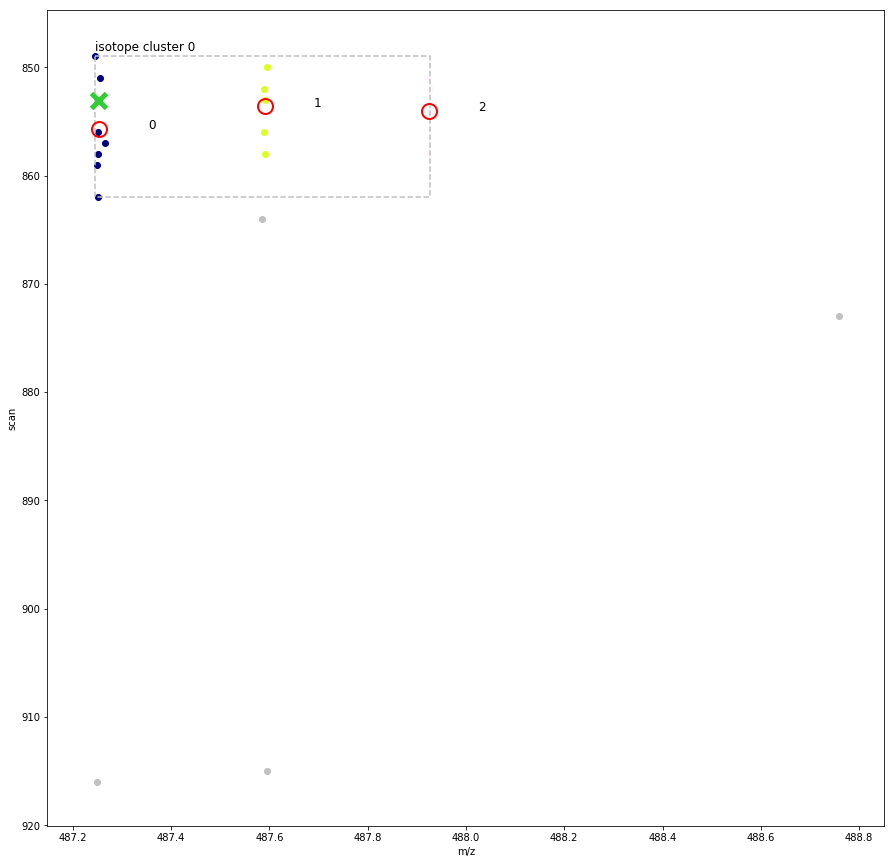

In [209]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)

df = candidate_region_df[(candidate_region_df.isotope_cluster >= 0)]
for group_name,group_df in df.groupby(['isotope_cluster'], as_index=False):
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)
    ax1.text(top_left[0], top_left[1]-0.5, 'isotope cluster {}'.format(int(group_name)), fontsize=12)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plot_xlim = ax1.get_xlim()
plot_ylim = ax1.get_ylim()

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [210]:
scan_lower, scan_upper

(849, 916)

In [211]:
rt_extract_df = rt_df[(rt_df.retention_time_secs >= rt_lower) & (rt_df.retention_time_secs <= rt_upper)]

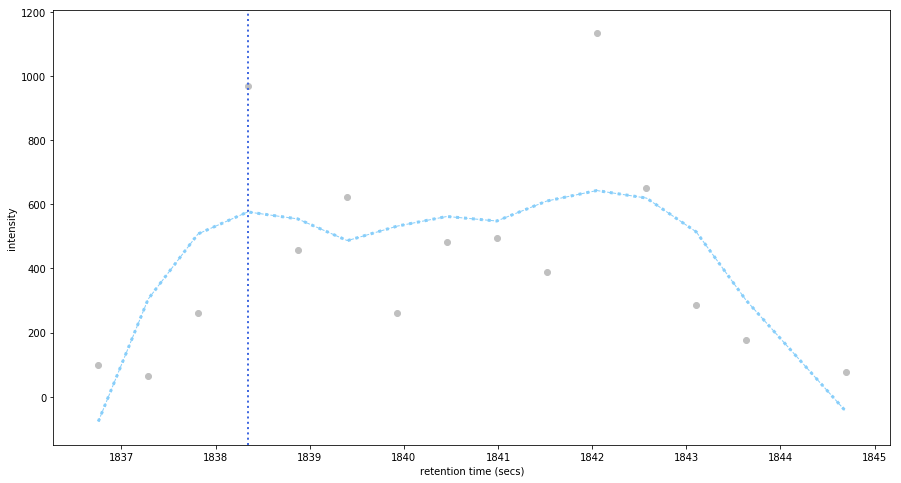

In [212]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_df.retention_time_secs, rt_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(rt_extract_df.retention_time_secs, rt_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(rt_valleys_df.retention_time_secs, rt_valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.axvline(x=anchor_point_s.retention_time_secs, linestyle=':', color='royalblue', linewidth=2, label='anchor point')

# plt.ylim(bottom=0)

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()